## Note
The paramters in this sample code are similar to  our main training code but we test this code on limited number of data for the sake of speed


## Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data directory 

In [ ]:
import glob
import os
import numpy as np
from tqdm import tqdm

folder_npy = '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train'

file_paths = glob.glob(os.path.join(folder_npy, '*.npy'))
file_paths.sort()
print(file_paths)
print(len(file_paths))

['/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0001_296_281_383_CR_P001.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0002_266_273_309_CR_P002.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0003_268_338_372_CR_P003.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0004_328_298_372_CR_P004.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0005_288_262_369_CR_P005.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0006_286_294_317_CR_P006.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0007_302_286_310_CR_P007.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0008_318_345_355_CR_P008.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0009_346_326_364_CR_P009.npy', '/content/drive/MyDrive/goo

In [ ]:
# Splite data for Health (h) class
h_path = file_paths[55:110]
print(h_path)

['/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0001_288_270_368_normal001.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0002_334_334_370_normal002.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0003_338_344_393_normal003.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0004_256_258_340_normal004.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0005_286_252_310_normal005.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0006_288_237_321_normal006.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0007_284_372_368_normal007.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0008_278_266_337_normal008.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/H_0009_290_292_365_normal009.npy', '/content/drive/MyDrive/googledrive_

## BCDU-net

In [ ]:
from __future__ import absolute_import
from __future__ import print_function

import os
import numpy as np

from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization, add
from keras.layers.core import Flatten, Reshape
from keras.models import Model
from keras.regularizers import l2
import keras.backend as K

def _shortcut(input, residual):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[1] / residual_shape[1]))
    stride_height = int(round(input_shape[2] / residual_shape[2]))
    equal_channels = input_shape[3] == residual_shape[3]

    shortcut = input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[3],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)

    return add([shortcut, residual])

def encoder_block(input_tensor, m, n):
    x = BatchNormalization()(input_tensor)
    x = Activation('relu')(x)
    x = Conv2D(filters=n, kernel_size=(3, 3), strides=(2, 2), padding="same")(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=n, kernel_size=(3, 3), padding="same")(x)

    added_1 = _shortcut(input_tensor, x)

    x = BatchNormalization()(added_1)
    x = Activation('relu')(x)
    x = Conv2D(filters=n, kernel_size=(3, 3), padding="same")(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=n, kernel_size=(3, 3), padding="same")(x)

    added_2 = _shortcut(added_1, x)

    return added_2

def decoder_block(input_tensor, m, n):
    x = BatchNormalization()(input_tensor)
    x = Activation('relu')(x)
    x = Conv2D(filters=int(m/4), kernel_size=(1, 1))(x)

    x = UpSampling2D((2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=int(m/4), kernel_size=(3, 3), padding='same')(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=n, kernel_size=(1, 1))(x)

    return x

def LinkNet(input_shape=(128, 128, 1), classes=1):
    inputs = Input(shape=input_shape)

    x = BatchNormalization()(inputs)
    x = Activation('relu')(x)
    x = Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2))(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

    encoder_1 = encoder_block(input_tensor=x, m=64, n=64)

    encoder_2 = encoder_block(input_tensor=encoder_1, m=64, n=128)

    encoder_3 = encoder_block(input_tensor=encoder_2, m=128, n=256)

    encoder_4 = encoder_block(input_tensor=encoder_3, m=256, n=512)

    decoder_4 = decoder_block(input_tensor=encoder_4, m=512, n=256)

    decoder_3_in = add([decoder_4, encoder_3])
    decoder_3_in = Activation('relu')(decoder_3_in)

    decoder_3 = decoder_block(input_tensor=decoder_3_in, m=256, n=128)

    decoder_2_in = add([decoder_3, encoder_2])
    decoder_2_in = Activation('relu')(decoder_2_in)

    decoder_2 = decoder_block(input_tensor=decoder_2_in, m=128, n=64)

    decoder_1_in = add([decoder_2, encoder_1])
    decoder_1_in = Activation('relu')(decoder_1_in)

    decoder_1 = decoder_block(input_tensor=decoder_1_in, m=64, n=64)

    x = UpSampling2D((2, 2))(decoder_1)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=32, kernel_size=(3, 3), padding="same")(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=32, kernel_size=(3, 3), padding="same")(x)

    x = UpSampling2D((2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=classes, kernel_size=(2, 2), padding="same")(x)

    model = Model(inputs=inputs, outputs=x)

    return model

In [ ]:
model = LinkNet(input_shape=(128, 128, 1), classes=1)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 1)  4           input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 1)  0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 61, 61, 64)   3200        activation[0][0]                 
______________________________________________________________________________________________

### Resizing the slices for BCDUNet model

In [ ]:
from skimage.transform import resize

In [ ]:
output = np.zeros((1,128,128))
for i in tqdm(h_path):
    data = np.load(i)
    data = resize(data, (data.shape[0],128, 128),anti_aliasing=True)
    output = np.append(output,data,axis=0)
output = output[1:]

100%|██████████| 55/55 [04:14<00:00,  4.63s/it]


### Adding noise

In [ ]:
!pip install noise

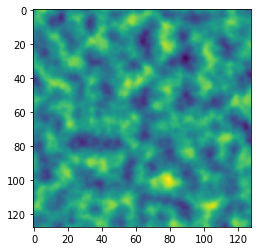

In [ ]:
import noise
import cv2
import numpy as np

def add_noise(input_array):
    shape = (128,128)
    scale = np.random.randint(10,30)
    # scale = 12
    # scale = 30
    octaves = 10
    persistence = 0.01*np.random.randint(-50,50)
    # persistence = 0.1
    lacunarity = 2.0
    seed = np.random.randint(0,1000)
    # seed = 33
    world = np.zeros(shape)
    for i in range(shape[0]):
        for j in range(shape[1]):
            world[i][j] = noise.pnoise2(i/scale, 
                                        j/scale, 
                                        octaves=octaves, 
                                        persistence=persistence, 
                                        lacunarity=lacunarity, 
                                        repeatx=140, 
                                        repeaty=140, 
                                        base=seed)
    return cv2.addWeighted(input_array, 1, world, 1, 0)  

import matplotlib.pyplot as plt
a  = np.zeros((128,128))
plt.imshow(add_noise(a)) 

In [ ]:
from tqdm import tqdm
noisy_output = np.zeros(output.shape)
for i in tqdm(range(output.shape[0])):
    noisy_output[i] = add_noise(output[i,:,:])

100%|██████████| 16448/16448 [07:54<00:00, 34.68it/s]


In [ ]:
'''
Change half of data to original slices (without noise)
Suggestion: you can use random permutation to clean half of data
suggestyion: you can change the rate of being nosisy or clean! 
'''
noisy_output[int(noisy_output.shape[0]/2):] = output[int(noisy_output.shape[0]/2):]

In [ ]:
#target (without noise)
output = np.reshape(output,(output.shape[0],output.shape[1],output.shape[2],1))

#input (half noisy)
noisy_output = np.reshape(noisy_output,(noisy_output.shape[0],noisy_output.shape[1],noisy_output.shape[2],1))

### Training the model

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(noisy_output, output,
            batch_size = 5,
            epochs = 3,
            shuffle=True,
            verbose=1)

Epoch 1/3
3290/3290 [==============================] - 99s 20ms/step - loss: 0.2686 - accuracy: 0.7801
Epoch 2/3
3290/3290 [==============================] - 64s 20ms/step - loss: 0.1003 - accuracy: 0.7799
Epoch 3/3
3290/3290 [==============================] - 65s 20ms/step - loss: 0.0883 - accuracy: 0.7812


In [ ]:
'''
However, you can save weights of your model for future use
'''
model.save_weights('/content/drive/My Drive/googledrive_segmentation/weight_half_lung_noisy_linknet.hdf5')


## 3D CNN model

In [ ]:
import glob
import os
import numpy as np
from tqdm import tqdm

folder_npy = '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train'

file_paths = glob.glob(os.path.join(folder_npy, '*.npy'))
file_paths.sort()
print(file_paths)
print(len(file_paths))

['/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0001_296_281_383_CR_P001.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0002_266_273_309_CR_P002.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0003_268_338_372_CR_P003.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0004_328_298_372_CR_P004.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0005_288_262_369_CR_P005.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0006_286_294_317_CR_P006.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0007_302_286_310_CR_P007.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0008_318_345_355_CR_P008.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0009_346_326_364_CR_P009.npy', '/content/drive/MyDrive/goo

In [ ]:
'''
Load all data to pass through BCDUNet to bold infections in out pipeline
Splite data for each class of COVID (c), Health or Control (h) and Pneumonia or CAP (p)

'''
c_path = file_paths[:55]
h_path = file_paths[55:110]
p_path = file_paths[110:165]
my_file_paths = c_path+h_path+p_path
print(my_file_paths)
print(len(my_file_paths))


['/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0001_296_281_383_CR_P001.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0002_266_273_309_CR_P002.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0003_268_338_372_CR_P003.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0004_328_298_372_CR_P004.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0005_288_262_369_CR_P005.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0006_286_294_317_CR_P006.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0007_302_286_310_CR_P007.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0008_318_345_355_CR_P008.npy', '/content/drive/MyDrive/googledrive_segmentation/ct-normal-slices-train/CPCR_0009_346_326_364_CR_P009.npy', '/content/drive/MyDrive/goo

### Go Through BCDUNet all slices and pack them

In [ ]:
'''
Here, we:
1- Resize different size of slices (2D) -> in x,y axes
2- Predict all slices of a patient using BCDUNET
3- Do subtraction
1- Resize different size of CT images (3D) -> in z axis
'''
from skimage.transform import resize
import numpy as np
from scipy import signal

dataset = np.zeros((len(my_file_paths),50,128,128))
counter = 0
for j in tqdm(my_file_paths):
    #print(j)
    CT = np.load(j)
    CT_resized = resize(CT, (CT.shape[0],128, 128),anti_aliasing=True)
    out = model.predict(np.reshape(CT_resized,(CT_resized.shape[0],CT_resized.shape[1],CT_resized.shape[2],1)))
    #out_resized = resize(out, (out.shape[0],128, 128),anti_aliasing=True)
    c = CT_resized-out[:,:,:,0]
    dataset[counter] = resize(c,(50,128,128))
    counter +=1

100%|██████████| 165/165 [16:06<00:00,  5.86s/it]


### Prepare labels

In [ ]:
'''
Based on the name of files (C: COVID, H: Health or Control, P: Pneumonia or CAP)
'''
lbl = np.zeros((165))
lbl[0:55] = 1 #COVID
lbl[55:110] = 0 #Control
lbl[110:165] = 2 #CAP
print(lbl)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


In [ ]:
'''
For saving the RAM, you can save the data and restart you runtime.
please import librarys again to continue
'''
np.save('/content/drive/My Drive/googledrive_segmentation/dataset_linknet.npy',dataset)
np.save('/content/drive/My Drive/googledrive_segmentation/lbl_linknet.npy',lbl)

### 3D CNN training

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D,Dropout
from keras.utils import to_categorical
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
dataset = np.load('/content/drive/My Drive/googledrive_segmentation/dataset_linknet.npy')
lbl = np.load('/content/drive/My Drive/googledrive_segmentation/lbl_linknet.npy')

In [ ]:
# reshape the dataset to feed to the model
dataset = np.reshape(dataset,(dataset.shape[0],dataset.shape[1],dataset.shape[2],dataset.shape[3],1))

In [ ]:
# for balancing data as the inputs of the model
c = np.random.permutation(np.arange(0,55))
h = np.random.permutation(np.arange(55,110))
p = np.random.permutation(np.arange(110,165))

train_index = np.random.permutation(np.append(np.append(c[0:40],h[0:40]),p[0:40]))
print('training set:', train_index)
validation_index = np.random.permutation(np.append(np.append(c[40:55],h[40:55]),p[40:55]))
print('validation set:',validation_index)

training set: [ 15  38  22 115 151  81 145  59  57 123  29 141 132  28  42  20 163  91
  98   3 155  92   6  95 126 133 113  24  80 154 101 150  63  44 147 116
  30  48   4  69 143  19   1  68 125 108  46  37 131   0  54  72   5 149
 139 128 120  75  34 121  40  11  84  78 148  86 152 136   8  55  13  23
 137  74  76  27  50 138   7  62  45  43  58  93 118  73  41 100 110 102
   9 103  14 144  90  83  56  53 135 112  87 117  85 134 119 158  61  49
  65 114  12 127  99  60  32  96 146  66  51  71]
validation set: [109  10 104 140   2 161  26 111 164  79  52 156  39 124  17 160  33  25
  18  31  70  77 106  67  89  16 122  35 107 159  36  82  47 142  94 105
  88 162  21  97 157 130 129 153  64]


In [ ]:
# Convert target vectors to categorical targets
targets_train = to_categorical(lbl[train_index]).astype(np.uint8)
targets_validation = to_categorical(lbl[validation_index]).astype(np.uint8)


In [ ]:
model = Sequential()
model.add(Conv3D(8, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(50,128,128,1)))
model.add(Conv3D(8, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same'))
model.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same'))
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same'))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same'))
model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 48, 126, 126, 8)   224       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 48, 126, 126, 8)   1736      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 24, 63, 63, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 24, 63, 63, 16)    3472      
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 24, 63, 63, 16)    6928      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 12, 31, 31, 16)    0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 12, 31, 31, 32)    1

In [ ]:
# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy, # or 'mse'
              optimizer=keras.optimizers.Adam(lr=0.0001),
              metrics=['accuracy'])


In [ ]:
# Fit data to model
history = model.fit(dataset[train_index], targets_train,
            batch_size=10, # batch_size = 16 in paper
            epochs=100, # epochs = 100 in paper
            verbose=1,
            shuffle = True,
            validation_data = (dataset[validation_index],targets_validation))

Epoch 1/100
12/12 [==============================] - 41s 519ms/step - loss: 1.9790 - accuracy: 0.2703 - val_loss: 1.0821 - val_accuracy: 0.4667
Epoch 2/100
12/12 [==============================] - 5s 450ms/step - loss: 1.0450 - accuracy: 0.4568 - val_loss: 1.0584 - val_accuracy: 0.4000
Epoch 3/100
12/12 [==============================] - 5s 451ms/step - loss: 1.0040 - accuracy: 0.4016 - val_loss: 1.0709 - val_accuracy: 0.4000
Epoch 4/100
12/12 [==============================] - 5s 451ms/step - loss: 1.0596 - accuracy: 0.4598 - val_loss: 1.0568 - val_accuracy: 0.5333
Epoch 5/100
12/12 [==============================] - 5s 453ms/step - loss: 1.0128 - accuracy: 0.5116 - val_loss: 1.0545 - val_accuracy: 0.4000
Epoch 6/100
12/12 [==============================] - 5s 456ms/step - loss: 0.9701 - accuracy: 0.4849 - val_loss: 1.0426 - val_accuracy: 0.5333
Epoch 7/100
12/12 [==============================] - 5s 457ms/step - loss: 0.9658 - accuracy: 0.5571 - val_loss: 1.0277 - val_accuracy: 0.422

In [ ]:
from sklearn import metrics
matrix = metrics.confusion_matrix(targets_validation.argmax(axis=1), model.predict(dataset[validation_index]).argmax(axis=1))

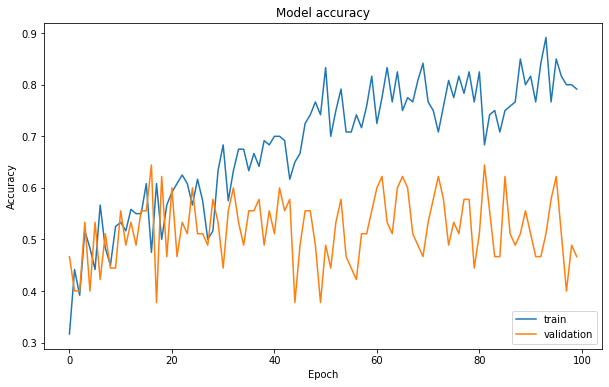

In [ ]:
import keras
from matplotlib import pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

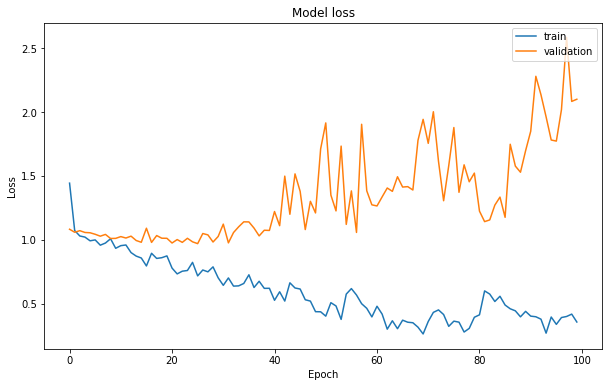

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### saving

In [ ]:
from keras.models import model_from_json

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("/content/drive/My Drive/googledrive_segmentation/weight_cnn_CovidCtNet2d.h5")